In [29]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

dtype = torch.float32

In [30]:
case_name = r'C:\Users\Noahc\Documents\USYD\tutorial\backwardFacingStep2D_v3\case.foam'
#case_name = r'C:\Users\Noahc\Documents\USYD\tutorial\backwardFacingStep2D_v2\backwardFacingStep2D_v2.foam'
vtk_file_reader = pv.POpenFOAMReader(case_name)
vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
vtk_mesh = vtk_file_reader.read()[0]

In [31]:
vtk_mesh['U']

pyvista_ndarray([[ 1.11909e+00,  3.30490e-01,  0.00000e+00],
                 [ 7.85952e-01,  3.56127e-02,  0.00000e+00],
                 [ 4.15858e-01,  4.98418e-03,  0.00000e+00],
                 ...,
                 [ 5.09364e-02, -5.29288e-03,  0.00000e+00],
                 [ 5.01795e-02, -5.22667e-03, -3.70713e-19],
                 [ 5.90714e-02, -6.10006e-03,  3.49657e-19]],
                dtype=float32)

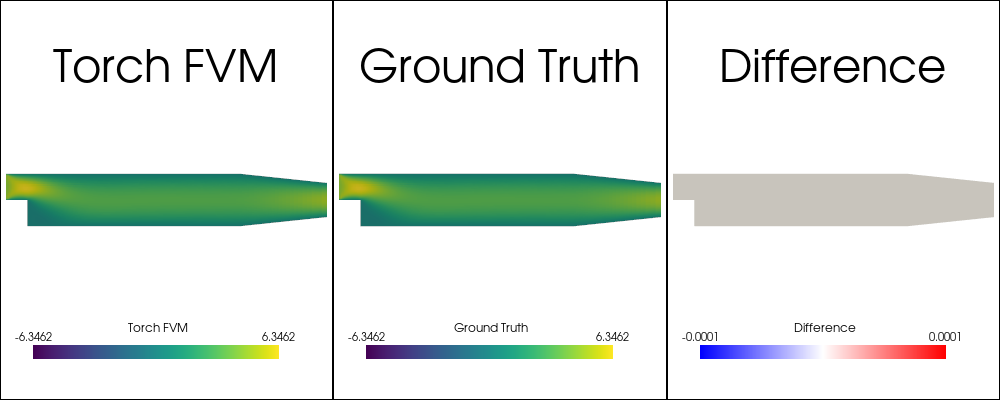

In [32]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=vtk_mesh['U'],
                    ground_truth = vtk_mesh['U'],
                    clims3=[-0.0001, 0.0001]
                    )

In [33]:
mom_x = vtk_mesh['divU_phi'] - 0.01* vtk_mesh['lapU'] + vtk_mesh['grad(p)']

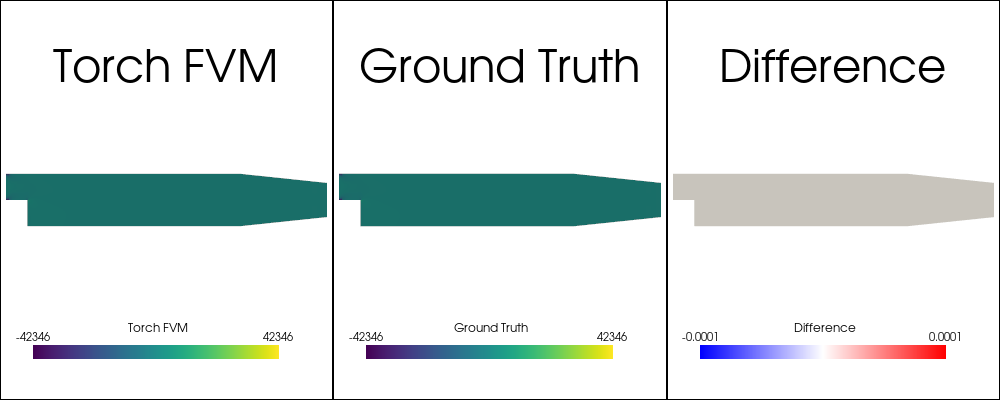

In [34]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=mom_x,
                    ground_truth = mom_x,
                    clims3=[-0.0001, 0.0001]
                    )

# TORCH FVM

In [7]:
U_bc_dict = {
            'inlet':{ "type":'fixedValue', "value":[44,0,0]},
            'upperWall':{ "type":'noSlip'},  
            'lowerWall':{ "type":'noSlip'},  
            'outlet':{ "type":'zeroGradient'},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
            'inlet':{ "type":'zeroGradient'},
            'upperWall':{ "type":'zeroGradient'},  
            'lowerWall':{ "type":'zeroGradient'},  
            'outlet':{ "type":'fixedValue', "value":[0]},  
            'frontAndBack':{ "type":'empty'}    
            }
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

In [41]:
L = 2.06
nu = 0.01
U_ref = 4.4
Re = U_ref*L/nu

In [36]:
mesh = gaus_green_vfm_mesh(vtk_file_reader, L = L, dtype = dtype, bc_dict=bc_dict)

Calculating face centers and areas for 49180 faces
{'max_non_orthogonality': 5.950516700744629, 'avg_non_orthogonality': 1.1061408519744873, 'max_skewness': 0.07527488470077515, 'avg_skewness': 0.0007278649136424065}
 Found Patch "inlet" with 30 Faces
 Found Patch "outlet" with 57 Faces
 Found Patch "upperWall" with 223 Faces
 Found Patch "lowerWall" with 250 Faces
Boundary faces indexed: 560/25010 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4003,               max w:0.5494,               mean w:0.4986


In [38]:
p_gt = torch.tensor(vtk_mesh['p'], dtype=dtype, device=mesh.device).unsqueeze(0).unsqueeze(0).unsqueeze(-1)/U_ref**2
U_gt = torch.tensor(vtk_mesh['U'], dtype=dtype, device=mesh.device).unsqueeze(0).unsqueeze(0)/U_ref

_, gradp_pred = Divergence_Operator.caclulate(mesh, field=p_gt, field_type='p')
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt)*nu

In [55]:
mom_pred = divU_pred #- (1/Re)*lap_pred# + gradp_pred

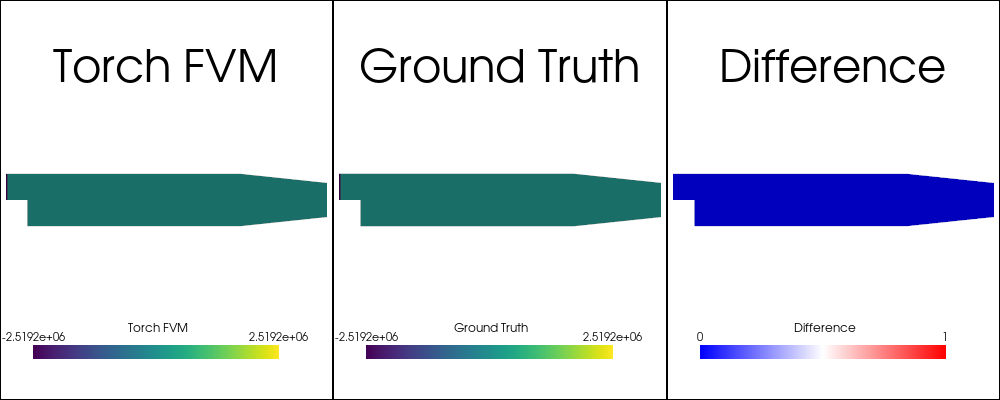

In [56]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=mom_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = mom_pred.squeeze(0).squeeze(0).numpy(),
                    #clims=[-100, 100]
                    )

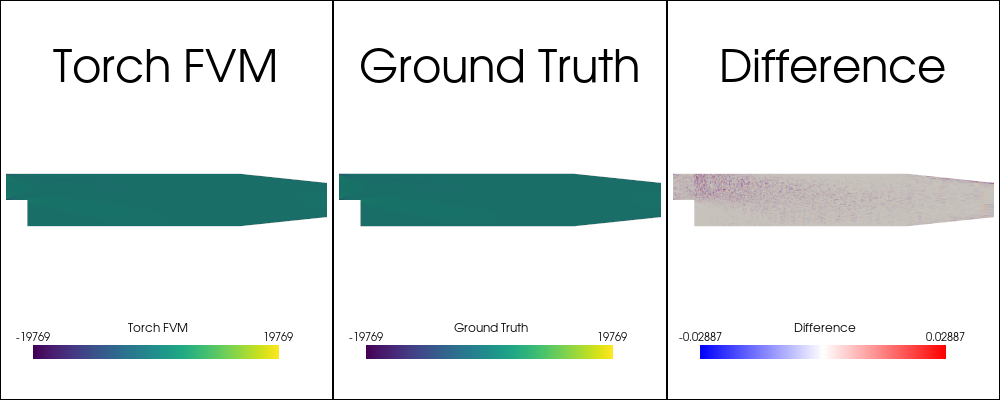

In [11]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = vtk_mesh['grad(U)'],
                    #clims3=[-0.0001, 0.0001]
                    )

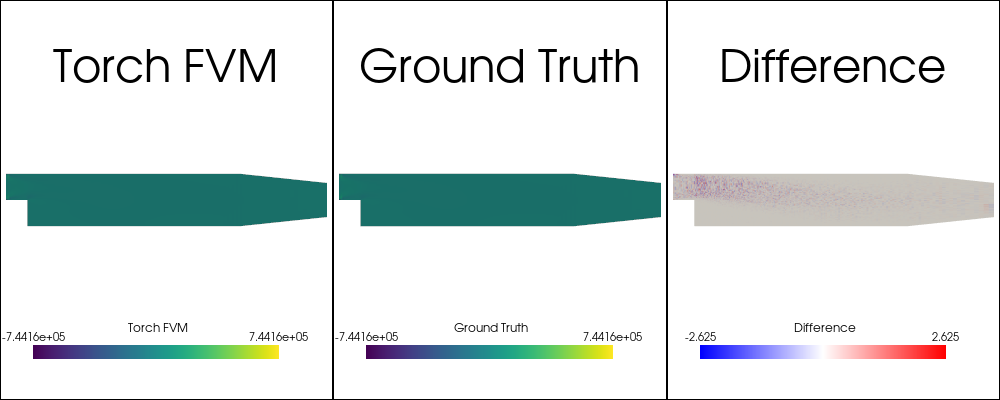

In [12]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = vtk_mesh['divU_phi'],
                    #clims3=[-0.0001, 0.0001]
                    )

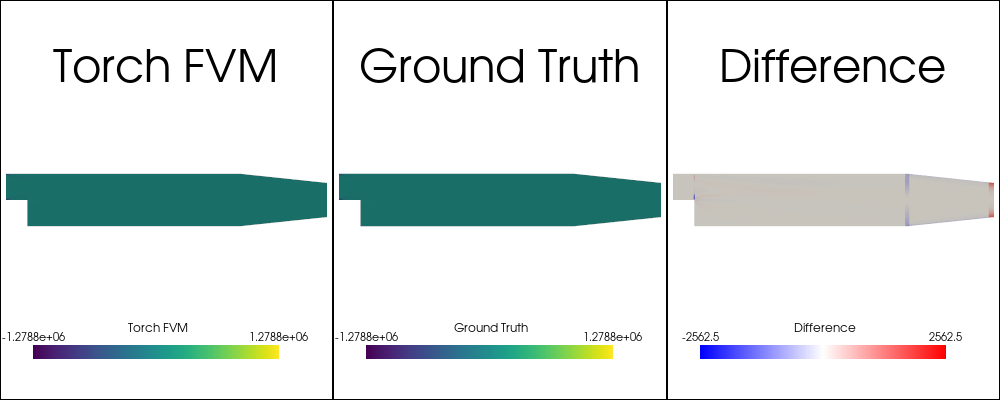

In [13]:
plot_comparison(vtk_mesh, None, f'mesh',i=0, interactive = True, point_label=False,
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = vtk_mesh['lapU'],
                    #clims3=[-0.0001, 0.0001]
                    )